### Preparation

In [ ]:
# Import library yang akan digunakan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mtp
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
df1 = pd.read_csv('/content/Mall_Customers.csv')

In [ ]:
df1

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


### Data Cleaning

In [ ]:
# Informasi data 1
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
#ganti nama kolom
df1.rename(columns={'Annual Income (k$)': 'Income', 'Spending Score (1-100)': 'Spending_Score'}, inplace=True)

In [ ]:
# hitung jumlah missing value di tiap kolom
df1.isna().sum()

,0
CustomerID,0
Gender,0
Age,0
Income,0
Spending_Score,0


In [ ]:
# Cek apakah terdapat duplikat di data kita
print(f"Terdapat {df1.duplicated().sum()} baris duplikat di data kita")

Terdapat 0 baris duplikat di data kita


In [ ]:
# cek apakah ada typo pada kolom string/object

kolom_string = ['Gender']

for col in df1[kolom_string]:
  print(df1[col].unique())

['Male' 'Female']


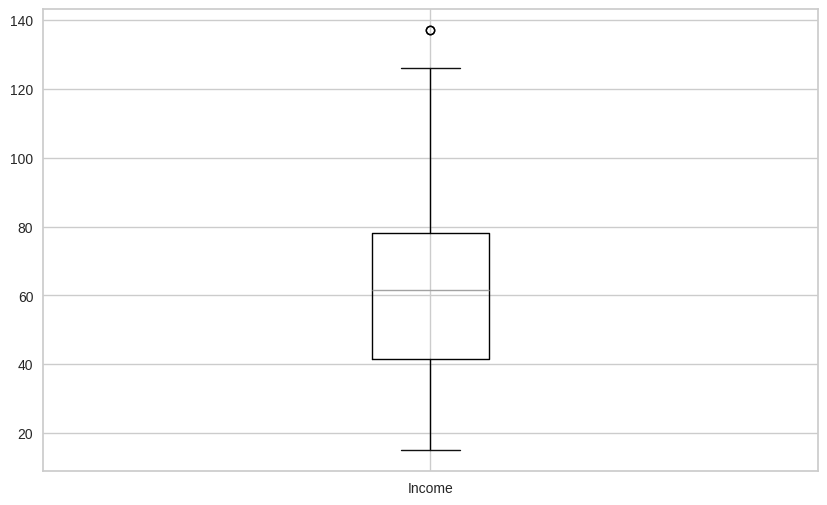

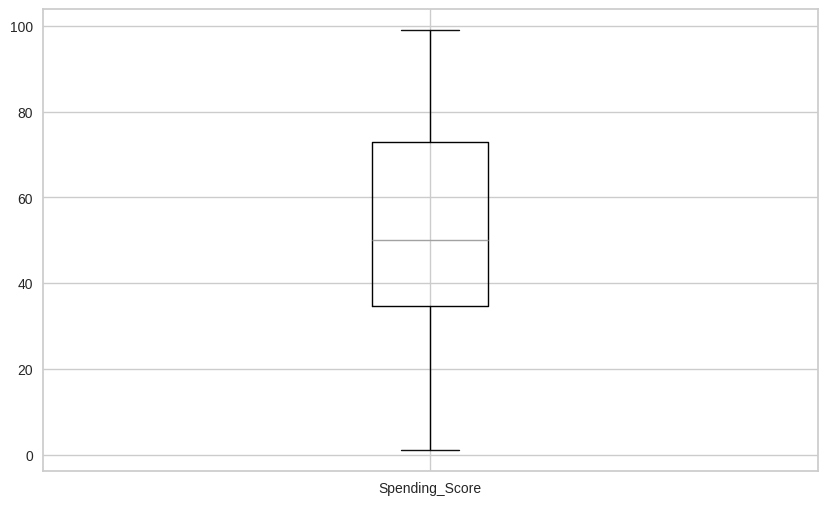

In [ ]:
# cek outlier untuk variabel numerik
numerik = ['Income','Spending_Score']

for i in df1[numerik]:
  plt.figure(figsize=(10,6))
  df1.boxplot(column=[i])

Dari output data 1 di atas, dapat disimpulkan bahwa:
*  Tidak terdapat missing value
* Ada data duplikat
* Terdapat outlier di Income

In [ ]:
#hapus outlier

IQR_Income = df1['Income'].quantile(0.75) - df1['Income'].quantile(0.25)
max = df1['Income'].quantile(0.75)+1.5*IQR_Income
df1 = df1[(df1['Income']<=max)]


### Feature Engineering

Feature Engineering dilakukan untuk proses memilih, mengubah, mengekstrak, menggabungkan, dan memanipulasi data mentah untuk menghasilkan variabel yang diinginkan untuk analisis atau pemodelan prediktif

Selanjutnya kita perlu eksplorasi nilai-nilai dalam fitur kategorikal untuk mendapatkan gambaran yang jelas tentang data fitur "Gender" seperti apa

In [ ]:
print("Total kategori dalam Gender:\n", df1["Gender"].value_counts())

Total kategori dalam Gender:
 Gender
Female    112
Male       86
Name: count, dtype: int64


Ada fitur dalam dtype: object (Gender). Jadi perlu mengkodekannya ke dalam bentuk numerik

In [ ]:
# Menggunakan "labelencoder" untuk transform categorical columns ke numeric karena berjenjang

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

label_encoder = preprocessing.LabelEncoder()

df1['Gender']= label_encoder.fit_transform(df1['Gender'])

<ipython-input-12-af6129025bae>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Gender']= label_encoder.fit_transform(df1['Gender'])


In [ ]:
df1.head()

,CustomerID,Gender,Age,Income,Spending_Score
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


**Gender**
1 : Male
0 : Female

In [ ]:
#drop customer ID
df1 = df1.drop(['CustomerID'], axis=1)

Karena Kmeans merupakan algoritma yang tergantung pada jarak sehingga perbedaan skala pada tiap feature sangat berpengaruh sehingga diperlukan Standarisasi agar mendapatkan means = 0 dan simpangan baku 1 pada tiap feature

In [ ]:
#standar sclaer

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df1)
scaled_df = pd.DataFrame(scaler.transform(df1),columns= df1.columns )



In [ ]:
scaled_df

,Gender,Age,Income,Spending_Score
0,1.141195,-1.425414,-1.779171,-0.435989
1,1.141195,-1.282367,-1.779171,1.199413
2,-0.876275,-1.353890,-1.739447,-1.720949
3,-0.876275,-1.139319,-1.739447,1.043661
4,-0.876275,-0.567131,-1.699723,-0.397051
...,...,...,...,...
193,-0.876275,-0.066466,2.113819,1.588795
194,-0.876275,0.577246,2.391890,-1.331567
195,-0.876275,-0.281037,2.391890,1.121537
196,-0.876275,0.434198,2.630236,-0.864309


array([[<Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Income'}>,
        <Axes: title={'center': 'Spending_Score'}>]], dtype=object)

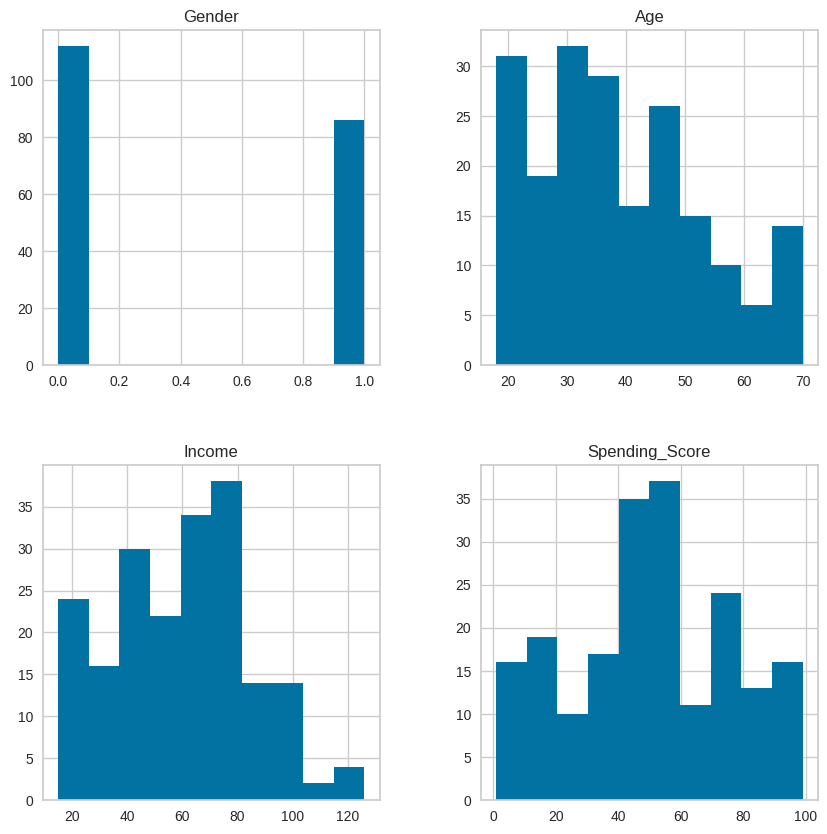

In [ ]:
df1.hist(figsize=(10,10))

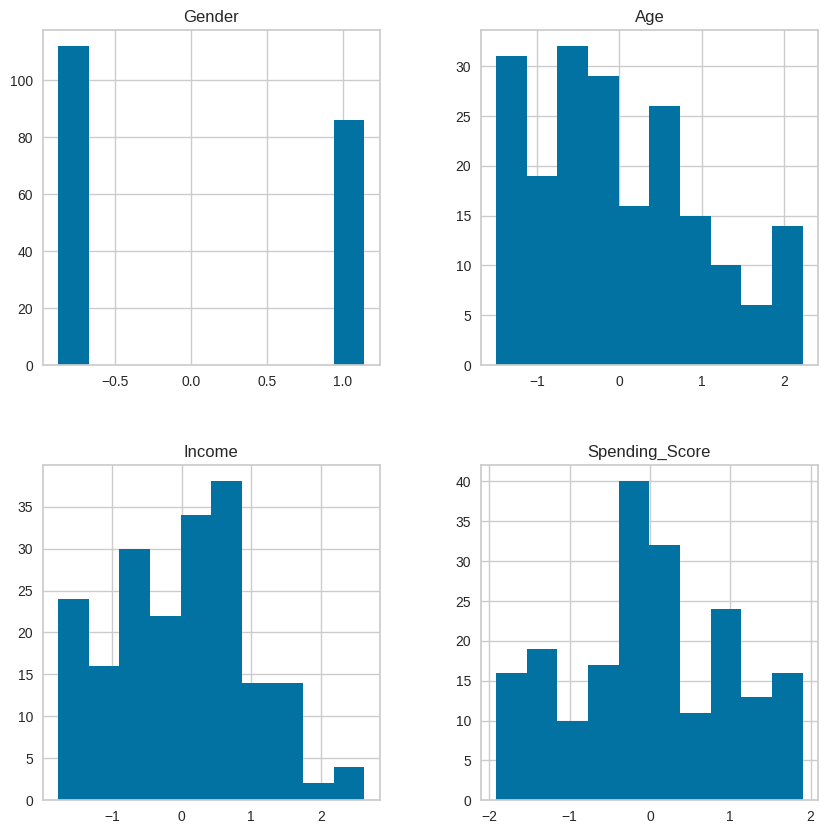

In [ ]:
#plot semua kolom menggunakan histogram
scaled_df.hist(figsize=(10,10))
plt.show()

### Clustering

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Gender          198 non-null    int64
 1   Age             198 non-null    int64
 2   Income          198 non-null    int64
 3   Spending_Score  198 non-null    int64
dtypes: int64(4)
memory usage: 7.7 KB


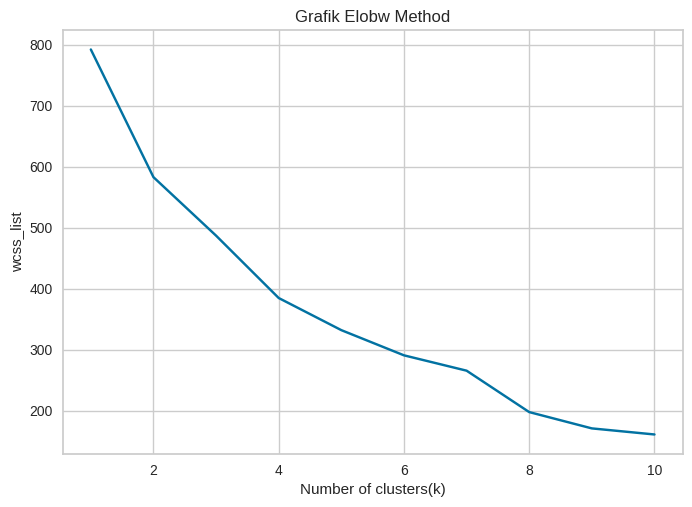

In [ ]:
#menemukan jumlah optimal dari cluster menggunakan elbow method
from sklearn.cluster import KMeans
wcss_list= []  #Inisialisasi list untuk nilai WCSS

#Menggunakan looping untuk iterasi dari 1 sampai 10.
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state= 42)
    kmeans.fit(scaled_df)
    wcss_list.append(kmeans.inertia_)
mtp.plot(range(1, 11), wcss_list)
mtp.title('Grafik Elobw Method')
mtp.xlabel('Number of clusters(k)')
mtp.ylabel('wcss_list')
mtp.show()

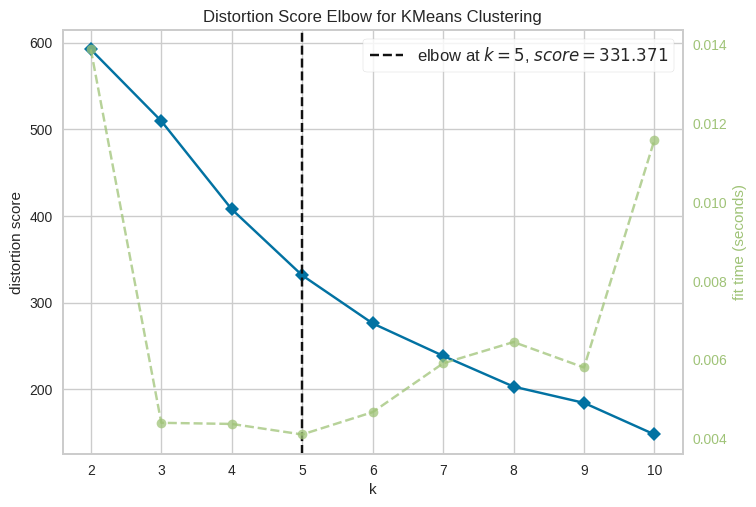

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(scaled_df)
Elbow_M.show()

In [ ]:
#melakukan training model dengan 5 kluster sesuai dengn titik elbow yang optimal
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(scaled_df)

In [ ]:
df1['cluster'] = y_kmeans

In [ ]:
df1.head()

,Gender,Age,Income,Spending_Score,cluster
0,1,19,15,39,2
1,1,21,15,81,2
2,0,20,16,6,2
3,0,23,16,77,2
4,0,31,17,40,2


In [ ]:
df1.groupby('cluster').mean()

,Gender,Age,Income,Spending_Score
cluster,,,,
0,1.000000,56.724138,48.068966,39.724138
1,0.447368,32.763158,85.210526,82.105263
2,0.423077,24.596154,39.211538,61.500000
3,0.000000,47.071429,55.767857,37.517857
4,0.782609,39.260870,88.869565,16.000000


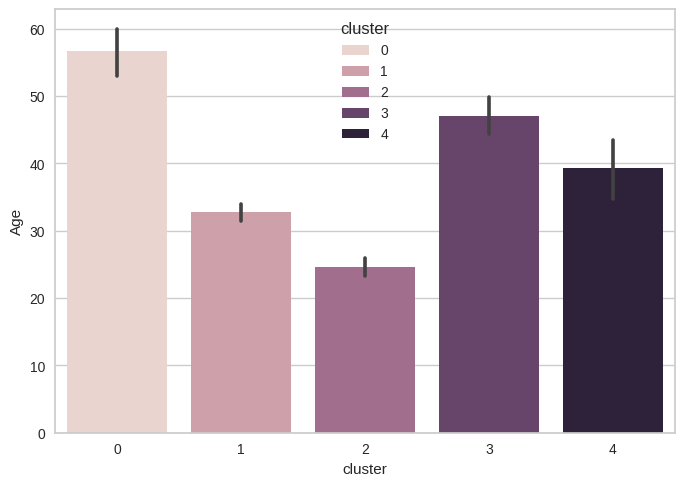

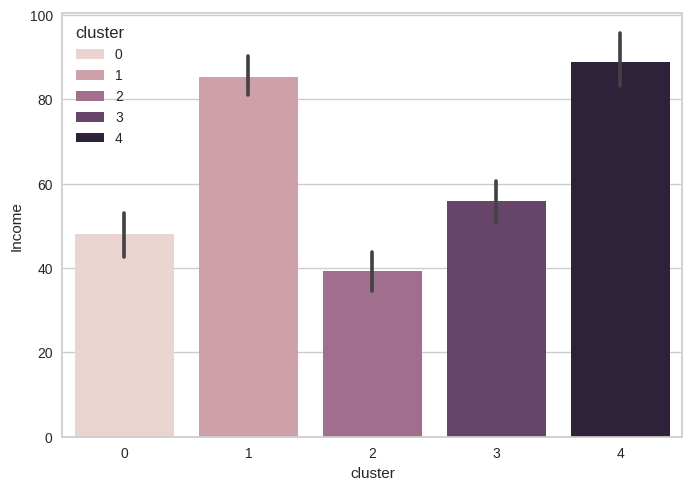

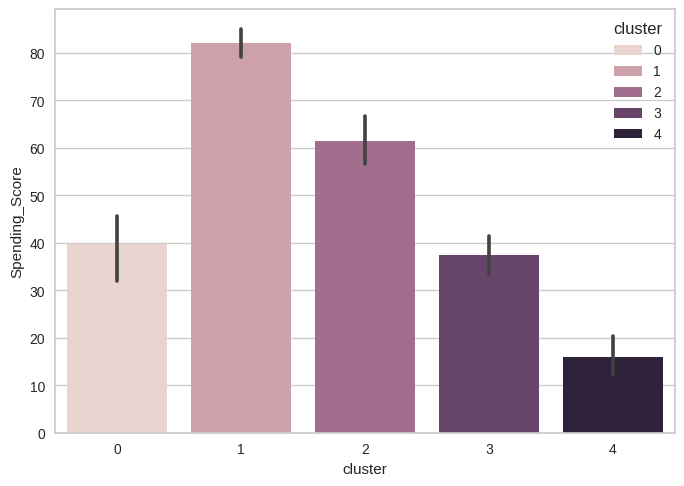

In [ ]:
#visualisasi cluster

personal_profile=['Age','Income','Spending_Score']

#count cluster by profile

for i in personal_profile:
  plt.figure()
  sns.barplot(data = df1, x=df1['cluster'],y=df1[i] ,hue=df1["cluster"])
  plt.show()


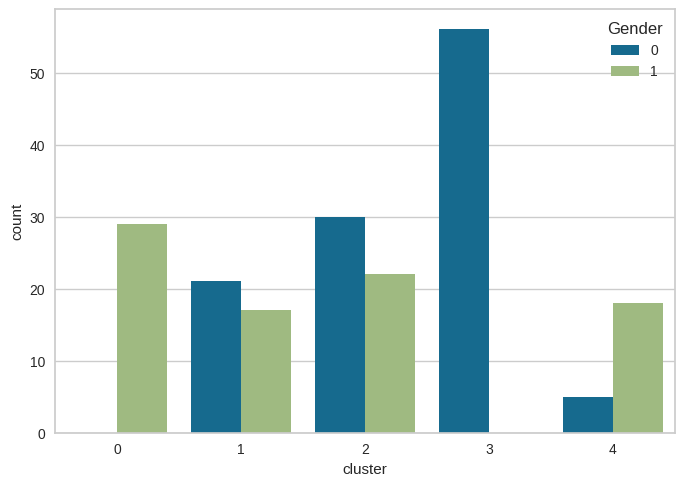

In [ ]:
plt.figure()
sns.countplot(x=df1['cluster'], hue=df1["Gender"])
plt.show()


Kesimpulan
*   Cluster 0: orang tua dengan gender pria, income rata-rata dan spending score rata-rata
*   Cluster 1: income yang cukup tinggi, spending score tinggi, rata-rata umur 30an dan relatif seimbang antara pria dan wanita
*   Cluster 2: umur paling muda, income paling sedikit namun spending score cukup tinggi, relatif seimbang antara pria dan wanita
*   Cluster 3: bergender wanita dengan umur 40an, income dan spending score rata-rata
*   Cluster 4: Income paling tinggi namun spending score paling rendah, didominasi oleh pria dengan rentang umur 35an









